
<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/062_Time_Series_Decomposition_STL.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/62_Time_Series_Decomposition_STL.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# 📉 STL: Czy to kryzys, czy tylko zima? (Dekompozycja Szeregów Czasowych)

Każdy wykres czasowy (Time Series) to suma trzech sił:
$$ Dane = Trend + Sezonowość + Szum $$

Mamy dwa główne modele:
1.  **Addytywny:** $Y = T + S + R$ (Amplituda fal jest stała, np. temperatura).
2.  **Multiplikatywny:** $Y = T \times S \times R$ (Amplituda rośnie wraz z trendem, np. sprzedaż w startupie - im więksi jesteśmy, tym większe górki w święta).

Użyjemy algorytmu **STL** (Seasonal-Trend decomposition using Loess), który jest standardem w analizie ekonomicznej, bo radzi sobie z outlierami lepiej niż zwykła średnia ruchoma.

Dane wygenerowane.


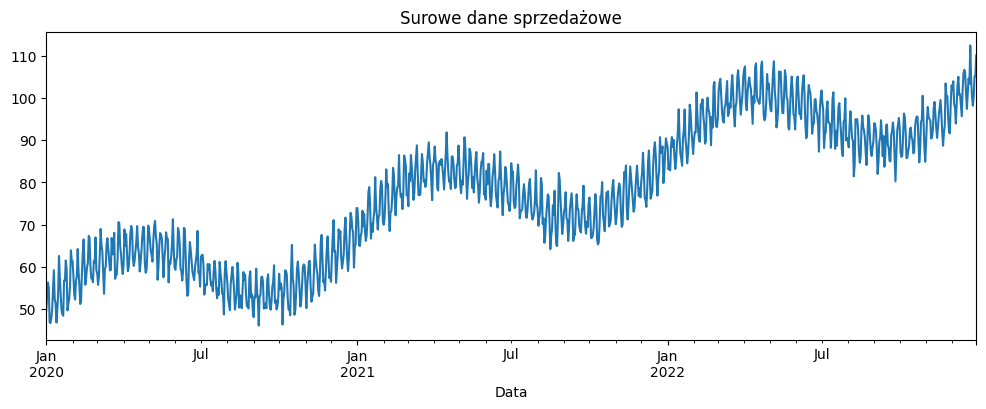

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose, STL

# 1. GENERUJEMY DANE (Symulacja E-commerce)
# Czas: 3 lata (36 miesięcy), dane dzienne
date_range = pd.date_range(start='2020-01-01', periods=365*3, freq='D')
t = np.arange(len(date_range))

# Składnik 1: TREND (Liniowy wzrost)
trend = 0.05 * t + 50 

# Składnik 2: SEZONOWOŚĆ (Roczna fala - sinusoida)
# 365 dni to jeden cykl (2*pi)
seasonality = 10 * np.sin(2 * np.pi * t / 365) 
# Dodajmy tygodniową sezonowość (weekendowe górki)
seasonality += 5 * np.sin(2 * np.pi * t / 7)

# Składnik 3: SZUM (Losowe wahania)
noise = np.random.normal(0, 2, len(t))

# SUMA (To co widzi analityk)
y = trend + seasonality + noise

# Tworzymy DataFrame
df = pd.DataFrame({'Data': date_range, 'Sprzedaz': y})
df.set_index('Data', inplace=True)

print("Dane wygenerowane.")
df['Sprzedaz'].plot(figsize=(12, 4), title="Surowe dane sprzedażowe")
plt.show()

## Metoda 1: Klasyczna Dekompozycja (Naive)

To najprostsza metoda.
1.  Liczysz średnią ruchomą (Moving Average) -> To jest **Trend**.
2.  Odejmujesz Trend od Danych.
3.  Uśredniasz to co zostało dla każdego dnia roku -> To jest **Sezonowość**.

Używamy `seasonal_decompose` z biblioteki `statsmodels`.

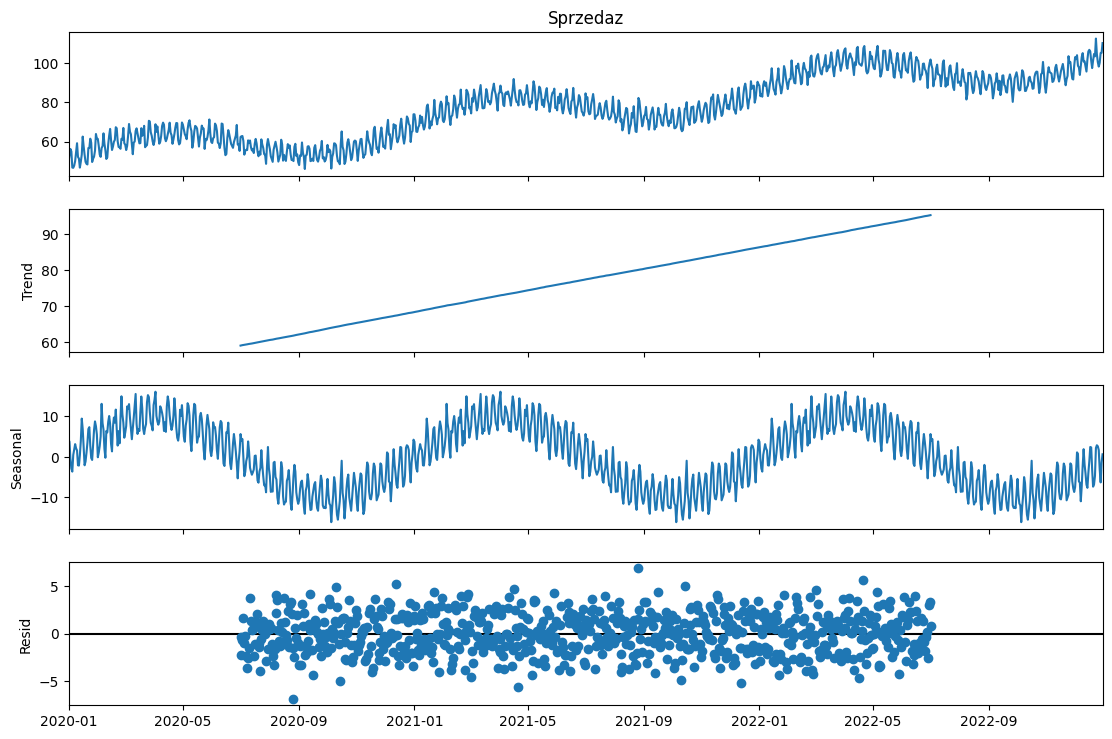

Zauważ:
- Trend jest gładki.
- Seasonal jest idealnie powtarzalny (nudny).
- Resid (Reszty) to to, czego model nie zrozumiał.


In [2]:
# period=365 (bo szukamy rocznej sezonowości)
result_naive = seasonal_decompose(df['Sprzedaz'], model='additive', period=365)

# Rysujemy
fig = result_naive.plot()
fig.set_size_inches(12, 8)
plt.show()

print("Zauważ:")
print("- Trend jest gładki.")
print("- Seasonal jest idealnie powtarzalny (nudny).")
print("- Resid (Reszty) to to, czego model nie zrozumiał.")

## Metoda 2: STL (Robust Decomposition)

Klasyczna metoda ma wadę: jest sztywna (sezonowość musi być stała).
**STL** jest mądrzejszy. Pozwala sezonowości **zmieniać się w czasie** (np. zimy stają się cieplejsze, więc sprzedaż kurtek spada z roku na rok wolniej).

To jest metoda, której powinieneś używać w pracy.

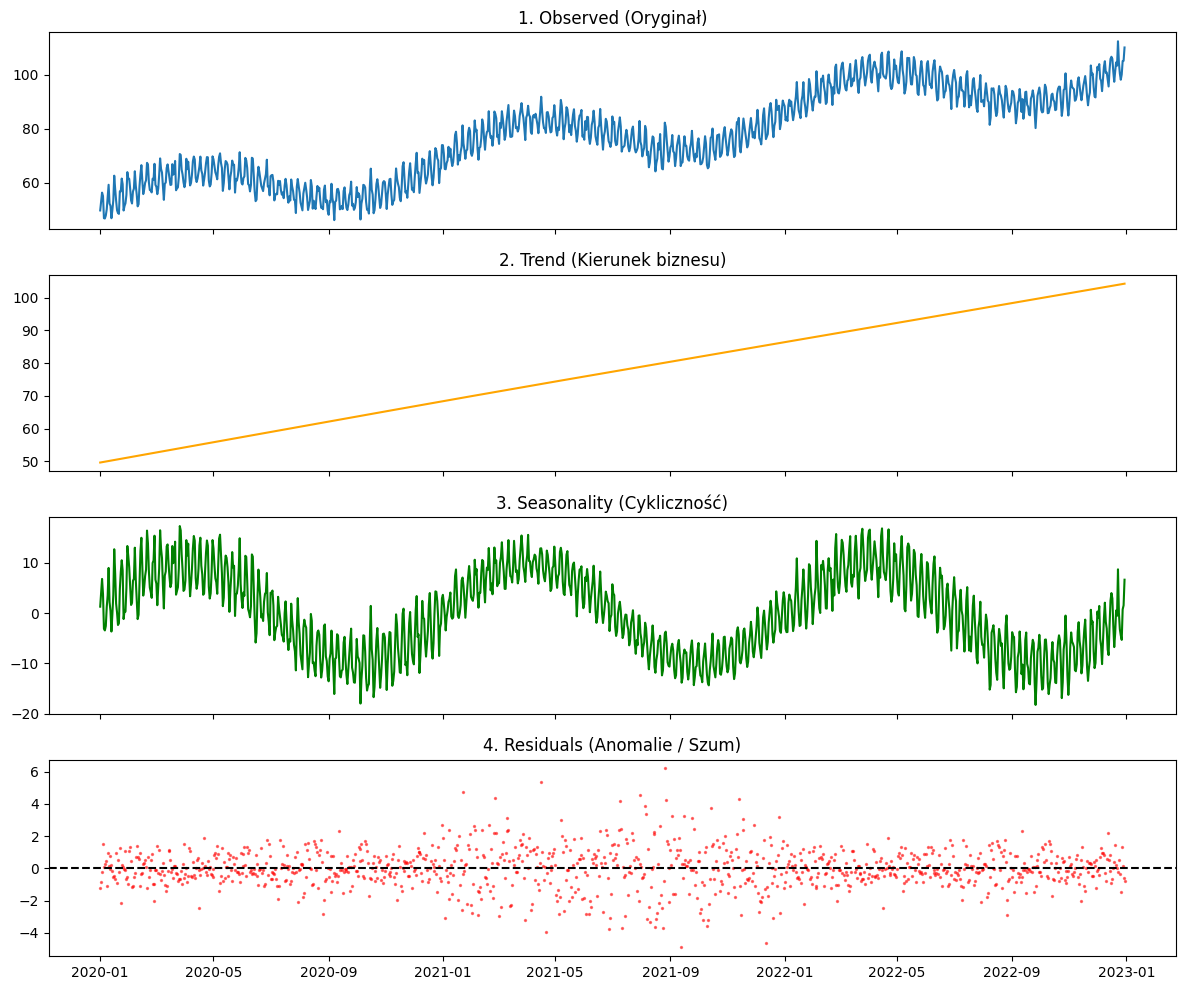

In [3]:
# STL automatycznie wykrywa wiele rzeczy, ale warto podać okres (period)
stl = STL(df['Sprzedaz'], period=365)
result_stl = stl.fit()

# Wizualizacja profesjonalna
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

axes[0].plot(result_stl.observed)
axes[0].set_title("1. Observed (Oryginał)")

axes[1].plot(result_stl.trend, color='orange')
axes[1].set_title("2. Trend (Kierunek biznesu)")

axes[2].plot(result_stl.seasonal, color='green')
axes[2].set_title("3. Seasonality (Cykliczność)")

axes[3].scatter(df.index, result_stl.resid, color='red', s=2, alpha=0.5)
axes[3].axhline(0, color='black', linestyle='--')
axes[3].set_title("4. Residuals (Anomalie / Szum)")

plt.tight_layout()
plt.show()

## Detekcja Anomalii na podstawie Reszt

To jest najpotężniejsze zastosowanie STL.
Skoro odjęliśmy Trend i Sezonowość, to co zostało w **Residuals**, to czysty przypadek.

Jeśli w Resztach pojawi się nagle wartość `+50`, to znaczy, że stało się coś dziwnego (np. Viral w social mediach albo błąd systemu), bo nie da się tego wytłumaczyć ani trendem, ani porą roku.

Granica błędu: +/- 3.69
Znaleziono 16 dni, które są podejrzenie dziwne.


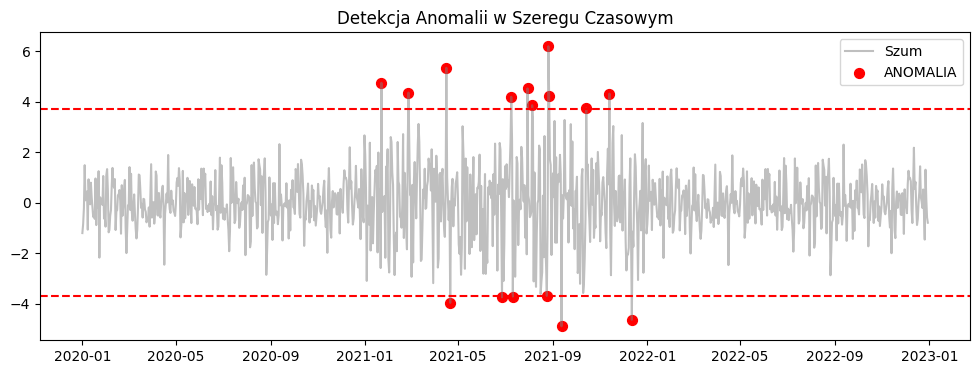

In [4]:
# Wyciągamy reszty
reszty = result_stl.resid

# Obliczamy granice normy (3 odchylenia standardowe)
mean_resid = np.mean(reszty)
std_resid = np.std(reszty)
threshold = 3 * std_resid

anomalie = reszty[abs(reszty) > threshold]

print(f"Granica błędu: +/- {threshold:.2f}")
print(f"Znaleziono {len(anomalie)} dni, które są podejrzenie dziwne.")

# Zaznaczmy je na wykresie
plt.figure(figsize=(12, 4))
plt.plot(reszty, label='Szum', color='gray', alpha=0.5)
plt.scatter(anomalie.index, anomalie, color='red', label='ANOMALIA', s=50)
plt.axhline(threshold, color='red', linestyle='--')
plt.axhline(-threshold, color='red', linestyle='--')
plt.title("Detekcja Anomalii w Szeregu Czasowym")
plt.legend()
plt.show()

## 🧠 Podsumowanie: Jak czytać ten wykres?

Gdy prezes pyta o spadek sprzedaży, patrzysz na wykres **nr 2 (Trend)**.
*   Jeśli Trend rośnie, a Sprzedaż (Oryginał) spadła -> **"Spokojnie, to tylko sezonowość (zima). Biznes rośnie."**
*   Jeśli Trend spada -> **"Mamy problem. Niezależnie od pory roku, tracimy rynek."**

STL pozwala Ci oddzielić szum informacyjny od sygnału biznesowego.